In [2]:
"""
Using EXACT Garg et al. transformer implementation
Simple training loop for your data format
"""

import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Config
import numpy as np
import time
from tqdm import tqdm
import json
import os

# ============================================================================
# EXACT GARG ET AL. TRANSFORMER (from their repo)
# ============================================================================

class TransformerModel(nn.Module):
    def __init__(self, n_dims, n_positions, n_embd=128, n_layer=12, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=2 * n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_dims
        self._read_in = nn.Linear(n_dims, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, 1)

    @staticmethod
    def _combine(xs_b, ys_b):
        """Interleaves the x's and the y's into a single sequence."""
        bsize, points, dim = xs_b.shape
        ys_b_wide = torch.cat(
            (
                ys_b.view(bsize, points, 1),
                torch.zeros(bsize, points, dim - 1, device=ys_b.device),
            ),
            axis=2,
        )
        zs = torch.stack((xs_b, ys_b_wide), dim=2)
        zs = zs.view(bsize, 2 * points, dim)
        return zs

    def forward(self, xs, ys, inds=None):
        """
        Forward pass for in-context learning.

        Args:
            xs: [batch, n_points, n_dims] - input features
            ys: [batch, n_points] - target values
            inds: indices to predict (if None, predicts all points)

        Returns:
            predictions: [batch, len(inds)] - predicted y values
        """
        if inds is None:
            inds = torch.arange(ys.shape[1])
        else:
            inds = torch.tensor(inds)
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        # Create interleaved sequence: [x0, y0, x1, y1, ..., x_{n-1}, y_{n-1}, x_n]
        # Key change: We include ALL (x,y) pairs in the sequence
        # The causal mask in GPT2 will prevent cheating
        zs = self._combine(xs, ys)

        # Process through transformer
        embeds = self._read_in(zs)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state

        # Predict at positions corresponding to x tokens: [0, 2, 4, 6, ...]
        # For true in-context learning, we read from the x positions
        prediction = self._read_out(output)
        predictions = prediction[:, ::2, 0]  # Extract predictions at x positions

        return predictions[:, inds]

# ============================================================================
# YOUR DATA LOADER
# ============================================================================

def load_data(data_path):
    """Load your isotropic_data.npz"""
    data = np.load(data_path)

    # Your format:
    # X_train: (16000, 10, 5)
    # y_train: (16000, 10)
    # X_test: (4000, 10, 5)
    # y_test: (4000, 10)

    train_xs = torch.from_numpy(data['X_train']).float()
    train_ys = torch.from_numpy(data['y_train']).float()
    test_xs = torch.from_numpy(data['X_test']).float()
    test_ys = torch.from_numpy(data['y_test']).float()

    return train_xs, train_ys, test_xs, test_ys

# ============================================================================
# TRAINING LOOP
# ============================================================================

def train_step(model, xs, ys, optimizer, device):
    """
    Training step with proper in-context learning setup.

    Key insight: We predict y_i using context [x0,y0, x1,y1, ..., x_{i-1},y_{i-1}, x_i]
    The GPT2 causal mask ensures we can't see y_i when predicting it.
    """
    xs = xs.to(device)
    ys = ys.to(device)

    optimizer.zero_grad()

    # Get predictions for all positions
    predictions = model(xs, ys)

    d = xs.shape[2]  # d = 5

    # Loss on ALL predictions
    # At position i, the model predicts y_i using x_i and all previous (x,y) pairs
    loss = ((predictions - ys) ** 2).mean() / d

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    return loss.item()


def eval_model(model, xs, ys, device, batch_size=64):
    """Evaluation with proper in-context learning - only evaluate last position."""
    model.eval()
    total_loss = 0
    n_batches = 0
    d = xs.shape[2]

    with torch.no_grad():
        for i in range(0, len(xs), batch_size):
            batch_xs = xs[i:i+batch_size].to(device)
            batch_ys = ys[i:i+batch_size].to(device)

            predictions = model(batch_xs, batch_ys)

            # Only evaluate the last prediction (max in-context learning)
            last_predictions = predictions[:, -1]  # Shape: (batch_size, d)
            last_targets = batch_ys[:, -1]         # Shape: (batch_size,)

            loss = ((last_predictions - last_targets) ** 2).mean() / d

            total_loss += loss.item()
            n_batches += 1

    model.train()
    return total_loss / n_batches


def train_model(model, train_xs, train_ys, test_xs, test_ys, config, device):
    """Main training loop"""

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    n_train = len(train_xs)
    best_test_loss = float('inf')

    history = {
        'train_loss': [],
        'test_loss': [],
        'step': [],
        'wall_time': []
    }

    start_time = time.time()
    step = 0

    print(f"\n{'='*70}")
    print(f"Training for {config['steps']} steps")
    print(f"Batch size: {config['batch_size']}")
    print(f"Train samples: {n_train}, Test samples: {len(test_xs)}")
    print(f"{'='*70}\n")

    pbar = tqdm(total=config['steps'], desc="Training")

    while step < config['steps']:
        # Sample random batch
        batch_idx = torch.randint(0, n_train, (config['batch_size'],))
        batch_xs = train_xs[batch_idx]
        batch_ys = train_ys[batch_idx]

        # Train step
        train_loss = train_step(model, batch_xs, batch_ys, optimizer, device)

        step += 1
        pbar.update(1)
        pbar.set_postfix({'loss': f'{train_loss:.4f}'})

        # Log every 500 steps
        if step % 500 == 0 or step == config['steps']:
            test_loss = eval_model(model, test_xs, test_ys, device, config['batch_size'])
            elapsed_time = time.time() - start_time

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['step'].append(step)
            history['wall_time'].append(elapsed_time)

            print(f"\nStep {step:5d} | Train Loss: {train_loss:.6f} | "
                  f"Test Loss: {test_loss:.6f} | Time: {elapsed_time/3600:.2f}h")

            # Save best model
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                torch.save({
                    'step': step,
                    'model_state_dict': model.state_dict(),
                    'test_loss': test_loss,
                    'wall_time': elapsed_time,
                }, config['checkpoint_path'])
                print(f"✓ Saved new best model (test_loss: {test_loss:.6f})")

    pbar.close()

    total_time = time.time() - start_time
    print(f"\n{'='*70}")
    print(f"Training complete!")
    print(f"Best test loss: {best_test_loss:.6f}")
    print(f"Total wall-clock time: {total_time/3600:.2f} hours")
    print(f"{'='*70}\n")

    return history

# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    # Set seed
    torch.manual_seed(42)
    np.random.seed(42)

    # Config

    # config = {
    # # data / prompt dimensions
    # 'n_dims': 5,         # input feature dimension (unchanged)
    # 'n_positions': 10,   # number of context points (unchanged)

    # # model parameters – increased
    # 'n_embd': 512,       # embedding dimension (2× larger than before)
    # 'n_layer': 12,       # 12 transformer blocks (2× deeper than before)
    # 'n_head': 8,         # 8 attention heads (2× more than before)

    # # training parameters
    # 'batch_size': 64,    # keep batch size modest to fit in memory
    # 'lr': 1e-4,          # same learning rate
    # 'steps': 20000,      # total training steps (adjust if training time gets too long)

    # # paths
    # 'data_path': 'data/isotropic_data.npz',
    # 'checkpoint_path': 'checkpoints/transformer_12layer_best.pt',
    # }

    config = {
        # Model params (6-layer as you specified)
        'n_dims': 5,         # your feature dimension
        'n_positions': 10,   # your context points
        'n_embd': 256,
        'n_layer': 6,        # YOUR DEPTH
        'n_head': 4,

        # Training params
        'batch_size': 32,
        'lr': 1e-4,          # Garg et al. use 1e-4
        'steps': 30000,      # 50k steps as in your proposal

        # Paths
        'data_path': 'data/isotropic_data.npz',
        'checkpoint_path': 'checkpoints/transformer_6layer_best.pt',
    }

    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('results', exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # Load your data
    print("Loading data...")
    train_xs, train_ys, test_xs, test_ys = load_data(config['data_path'])
    print(f"Train: {train_xs.shape}, Test: {test_xs.shape}")

    # Create model (EXACT Garg et al. architecture)
    print("\nInitializing transformer model...")
    model = TransformerModel(
        n_dims=config['n_dims'],
        n_positions=config['n_positions'],
        n_embd=config['n_embd'],
        n_layer=config['n_layer'],
        n_head=config['n_head']
    )


    n_params = sum(p.numel() for p in model.parameters())
    print(f"Model: {model.name}")
    print(f"Total parameters: {n_params:,}")

    # model.load_state_dict(torch.load('checkpoints/transformer_6layer_best.pt')['model_state_dict'])

    # Train
    print("\nStarting training...")
    history = train_model(
        model,
        train_xs, train_ys,
        test_xs, test_ys,
        config,
        device
    )

    # Save history
    history_path = 'results/training_history_6layer.json'
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)

    print(f"\nHistory saved to {history_path}")

Using device: cuda

Loading data...
Train: torch.Size([16000, 10, 5]), Test: torch.Size([4000, 10, 5])

Initializing transformer model...
Model: gpt2_embd=256_layer=6_head=4
Total parameters: 17,611,777

Starting training...

Training for 30000 steps
Batch size: 32
Train samples: 16000, Test samples: 4000



Training:   2%|▏         | 504/30000 [00:14<53:04,  9.26it/s, loss=1.3898]


Step   500 | Train Loss: 0.956726 | Test Loss: 1.017821 | Time: 0.00h
✓ Saved new best model (test_loss: 1.017821)


Training:   3%|▎         | 1002/30000 [00:27<53:58,  8.96it/s, loss=0.9549]


Step  1000 | Train Loss: 0.978227 | Test Loss: 0.908351 | Time: 0.01h
✓ Saved new best model (test_loss: 0.908351)


Training:   5%|▌         | 1500/30000 [00:39<10:52, 43.68it/s, loss=0.6131]


Step  1500 | Train Loss: 0.613121 | Test Loss: 0.639272 | Time: 0.01h
✓ Saved new best model (test_loss: 0.639272)


Training:   7%|▋         | 2002/30000 [00:55<13:58, 33.40it/s, loss=0.5749]


Step  2000 | Train Loss: 0.755428 | Test Loss: 0.584374 | Time: 0.02h
✓ Saved new best model (test_loss: 0.584374)


Training:   8%|▊         | 2502/30000 [01:08<11:31, 39.74it/s, loss=0.5754]


Step  2500 | Train Loss: 0.603721 | Test Loss: 0.533949 | Time: 0.02h
✓ Saved new best model (test_loss: 0.533949)


Training:  10%|█         | 3002/30000 [01:22<10:28, 42.98it/s, loss=0.5864]


Step  3000 | Train Loss: 0.736722 | Test Loss: 0.501548 | Time: 0.02h
✓ Saved new best model (test_loss: 0.501548)


Training:  12%|█▏        | 3502/30000 [01:36<48:54,  9.03it/s, loss=0.6664]


Step  3500 | Train Loss: 0.626042 | Test Loss: 0.474077 | Time: 0.03h
✓ Saved new best model (test_loss: 0.474077)


Training:  13%|█▎        | 4002/30000 [01:49<09:47, 44.28it/s, loss=0.6496]


Step  4000 | Train Loss: 0.567646 | Test Loss: 0.423099 | Time: 0.03h
✓ Saved new best model (test_loss: 0.423099)


Training:  15%|█▌        | 4502/30000 [02:02<47:40,  8.91it/s, loss=0.5287]


Step  4500 | Train Loss: 0.845318 | Test Loss: 0.415324 | Time: 0.03h
✓ Saved new best model (test_loss: 0.415324)


Training:  17%|█▋        | 5002/30000 [02:16<09:37, 43.32it/s, loss=0.5845]


Step  5000 | Train Loss: 0.602950 | Test Loss: 0.376099 | Time: 0.04h
✓ Saved new best model (test_loss: 0.376099)


Training:  18%|█▊        | 5500/30000 [02:28<09:35, 42.59it/s, loss=0.4619]


Step  5500 | Train Loss: 0.461949 | Test Loss: 0.332027 | Time: 0.04h


Training:  18%|█▊        | 5506/30000 [02:30<39:14, 10.40it/s, loss=0.5455]

✓ Saved new best model (test_loss: 0.332027)


Training:  20%|██        | 6001/30000 [02:43<58:37,  6.82it/s, loss=0.3862]


Step  6000 | Train Loss: 0.521953 | Test Loss: 0.288529 | Time: 0.05h
✓ Saved new best model (test_loss: 0.288529)


Training:  22%|██▏       | 6502/30000 [02:57<09:55, 39.44it/s, loss=0.4690]


Step  6500 | Train Loss: 0.469509 | Test Loss: 0.257788 | Time: 0.05h
✓ Saved new best model (test_loss: 0.257788)


Training:  23%|██▎       | 7002/30000 [03:11<44:15,  8.66it/s, loss=0.4507]


Step  7000 | Train Loss: 0.388626 | Test Loss: 0.235567 | Time: 0.05h
✓ Saved new best model (test_loss: 0.235567)


Training:  25%|██▌       | 7502/30000 [03:24<08:24, 44.60it/s, loss=0.5647]


Step  7500 | Train Loss: 0.419382 | Test Loss: 0.187996 | Time: 0.06h
✓ Saved new best model (test_loss: 0.187996)


Training:  27%|██▋       | 8002/30000 [03:38<08:14, 44.49it/s, loss=0.4404]


Step  8000 | Train Loss: 0.476143 | Test Loss: 0.170437 | Time: 0.06h
✓ Saved new best model (test_loss: 0.170437)


Training:  28%|██▊       | 8502/30000 [03:51<08:51, 40.42it/s, loss=0.4084]


Step  8500 | Train Loss: 0.489624 | Test Loss: 0.153106 | Time: 0.06h
✓ Saved new best model (test_loss: 0.153106)


Training:  30%|███       | 9002/30000 [04:05<40:09,  8.72it/s, loss=0.4338]


Step  9000 | Train Loss: 0.375179 | Test Loss: 0.135622 | Time: 0.07h
✓ Saved new best model (test_loss: 0.135622)


Training:  32%|███▏      | 9500/30000 [04:17<08:00, 42.69it/s, loss=0.3543]


Step  9500 | Train Loss: 0.354339 | Test Loss: 0.118606 | Time: 0.07h
✓ Saved new best model (test_loss: 0.118606)


Training:  33%|███▎      | 10002/30000 [04:33<53:42,  6.21it/s, loss=0.3646]


Step 10000 | Train Loss: 0.387300 | Test Loss: 0.111109 | Time: 0.08h
✓ Saved new best model (test_loss: 0.111109)


Training:  35%|███▌      | 10502/30000 [04:47<37:57,  8.56it/s, loss=0.3296]


Step 10500 | Train Loss: 0.417763 | Test Loss: 0.106829 | Time: 0.08h
✓ Saved new best model (test_loss: 0.106829)


Training:  37%|███▋      | 11002/30000 [05:00<36:24,  8.70it/s, loss=0.3388]


Step 11000 | Train Loss: 0.338384 | Test Loss: 0.090367 | Time: 0.08h
✓ Saved new best model (test_loss: 0.090367)


Training:  38%|███▊      | 11508/30000 [05:14<24:28, 12.60it/s, loss=0.3998]


Step 11500 | Train Loss: 0.335236 | Test Loss: 0.092637 | Time: 0.09h


Training:  40%|████      | 12002/30000 [05:27<33:48,  8.87it/s, loss=0.3491]


Step 12000 | Train Loss: 0.359302 | Test Loss: 0.080354 | Time: 0.09h
✓ Saved new best model (test_loss: 0.080354)


Training:  42%|████▏     | 12501/30000 [05:41<07:00, 41.66it/s, loss=0.3683]


Step 12500 | Train Loss: 0.328015 | Test Loss: 0.071958 | Time: 0.09h
✓ Saved new best model (test_loss: 0.071958)


Training:  43%|████▎     | 13001/30000 [05:55<06:21, 44.59it/s, loss=0.3806]


Step 13000 | Train Loss: 0.311771 | Test Loss: 0.070380 | Time: 0.10h
✓ Saved new best model (test_loss: 0.070380)


Training:  45%|████▌     | 13500/30000 [06:07<06:13, 44.23it/s, loss=0.4297]


Step 13500 | Train Loss: 0.429736 | Test Loss: 0.064755 | Time: 0.10h
✓ Saved new best model (test_loss: 0.064755)


Training:  47%|████▋     | 14008/30000 [06:22<28:18,  9.41it/s, loss=0.2422]


Step 14000 | Train Loss: 0.316970 | Test Loss: 0.065500 | Time: 0.11h


Training:  48%|████▊     | 14502/30000 [06:36<29:56,  8.63it/s, loss=0.2775]


Step 14500 | Train Loss: 0.312594 | Test Loss: 0.064057 | Time: 0.11h
✓ Saved new best model (test_loss: 0.064057)


Training:  50%|█████     | 15002/30000 [06:49<05:49, 42.92it/s, loss=0.3315]


Step 15000 | Train Loss: 0.403085 | Test Loss: 0.061256 | Time: 0.11h
✓ Saved new best model (test_loss: 0.061256)


Training:  52%|█████▏    | 15502/30000 [07:03<05:30, 43.83it/s, loss=0.2795]


Step 15500 | Train Loss: 0.253803 | Test Loss: 0.057668 | Time: 0.12h
✓ Saved new best model (test_loss: 0.057668)


Training:  53%|█████▎    | 16002/30000 [07:17<26:13,  8.89it/s, loss=0.3258]


Step 16000 | Train Loss: 0.270207 | Test Loss: 0.055866 | Time: 0.12h
✓ Saved new best model (test_loss: 0.055866)


Training:  55%|█████▌    | 16502/30000 [07:31<05:15, 42.84it/s, loss=0.3120]


Step 16500 | Train Loss: 0.306576 | Test Loss: 0.050252 | Time: 0.13h
✓ Saved new best model (test_loss: 0.050252)


Training:  57%|█████▋    | 17008/30000 [07:44<17:36, 12.30it/s, loss=0.2508]


Step 17000 | Train Loss: 0.268595 | Test Loss: 0.052904 | Time: 0.13h


Training:  58%|█████▊    | 17502/30000 [07:59<05:05, 40.86it/s, loss=0.2927]


Step 17500 | Train Loss: 0.249635 | Test Loss: 0.049990 | Time: 0.13h
✓ Saved new best model (test_loss: 0.049990)


Training:  60%|██████    | 18002/30000 [08:12<26:36,  7.52it/s, loss=0.3147]


Step 18000 | Train Loss: 0.255564 | Test Loss: 0.049529 | Time: 0.14h
✓ Saved new best model (test_loss: 0.049529)


Training:  62%|██████▏   | 18508/30000 [08:26<15:36, 12.27it/s, loss=0.2701]


Step 18500 | Train Loss: 0.334155 | Test Loss: 0.050585 | Time: 0.14h


Training:  63%|██████▎   | 19002/30000 [08:40<20:20,  9.01it/s, loss=0.2830]


Step 19000 | Train Loss: 0.283165 | Test Loss: 0.046897 | Time: 0.14h
✓ Saved new best model (test_loss: 0.046897)


Training:  65%|██████▌   | 19502/30000 [08:53<04:15, 41.16it/s, loss=0.2500]


Step 19500 | Train Loss: 0.282458 | Test Loss: 0.046786 | Time: 0.15h
✓ Saved new best model (test_loss: 0.046786)


Training:  67%|██████▋   | 20008/30000 [09:07<13:16, 12.55it/s, loss=0.3517]


Step 20000 | Train Loss: 0.252687 | Test Loss: 0.046838 | Time: 0.15h


Training:  68%|██████▊   | 20502/30000 [09:20<17:57,  8.82it/s, loss=0.2769]


Step 20500 | Train Loss: 0.212275 | Test Loss: 0.043913 | Time: 0.16h
✓ Saved new best model (test_loss: 0.043913)


Training:  70%|███████   | 21007/30000 [09:34<14:03, 10.66it/s, loss=0.2990]


Step 21000 | Train Loss: 0.203874 | Test Loss: 0.044113 | Time: 0.16h


Training:  72%|███████▏  | 21508/30000 [09:48<15:25,  9.18it/s, loss=0.2550]


Step 21500 | Train Loss: 0.250864 | Test Loss: 0.046961 | Time: 0.16h


Training:  73%|███████▎  | 22002/30000 [10:02<03:12, 41.63it/s, loss=0.2177]


Step 22000 | Train Loss: 0.222824 | Test Loss: 0.041969 | Time: 0.17h
✓ Saved new best model (test_loss: 0.041969)


Training:  75%|███████▌  | 22508/30000 [10:16<10:09, 12.30it/s, loss=0.2662]


Step 22500 | Train Loss: 0.252339 | Test Loss: 0.044135 | Time: 0.17h


Training:  77%|███████▋  | 23008/30000 [10:29<09:21, 12.46it/s, loss=0.1758]


Step 23000 | Train Loss: 0.175772 | Test Loss: 0.042193 | Time: 0.17h


Training:  78%|███████▊  | 23508/30000 [10:43<08:35, 12.59it/s, loss=0.2269]


Step 23500 | Train Loss: 0.262291 | Test Loss: 0.042862 | Time: 0.18h


Training:  80%|████████  | 24009/30000 [10:56<07:56, 12.57it/s, loss=0.2409]


Step 24000 | Train Loss: 0.228146 | Test Loss: 0.044707 | Time: 0.18h


Training:  82%|████████▏ | 24508/30000 [11:10<09:35,  9.54it/s, loss=0.2330]


Step 24500 | Train Loss: 0.234939 | Test Loss: 0.044142 | Time: 0.19h


Training:  83%|████████▎ | 25000/30000 [11:22<01:57, 42.42it/s, loss=0.1734]


Step 25000 | Train Loss: 0.173438 | Test Loss: 0.039389 | Time: 0.19h
✓ Saved new best model (test_loss: 0.039389)


Training:  85%|████████▌ | 25508/30000 [11:38<07:58,  9.39it/s, loss=0.1737]


Step 25500 | Train Loss: 0.184560 | Test Loss: 0.045206 | Time: 0.19h


Training:  87%|████████▋ | 26009/30000 [11:51<05:23, 12.33it/s, loss=0.1443]


Step 26000 | Train Loss: 0.180285 | Test Loss: 0.042652 | Time: 0.20h


Training:  88%|████████▊ | 26508/30000 [12:05<06:05,  9.55it/s, loss=0.2812]


Step 26500 | Train Loss: 0.246705 | Test Loss: 0.040467 | Time: 0.20h


Training:  90%|█████████ | 27009/30000 [12:18<03:57, 12.60it/s, loss=0.1875]


Step 27000 | Train Loss: 0.235298 | Test Loss: 0.039664 | Time: 0.21h


Training:  92%|█████████▏| 27508/30000 [12:32<03:19, 12.52it/s, loss=0.1856]


Step 27500 | Train Loss: 0.176192 | Test Loss: 0.040472 | Time: 0.21h


Training:  93%|█████████▎| 28008/30000 [12:46<04:02,  8.23it/s, loss=0.1599]


Step 28000 | Train Loss: 0.163815 | Test Loss: 0.040170 | Time: 0.21h


Training:  95%|█████████▌| 28508/30000 [12:59<02:00, 12.42it/s, loss=0.1796]


Step 28500 | Train Loss: 0.158738 | Test Loss: 0.040441 | Time: 0.22h


Training:  97%|█████████▋| 29000/30000 [13:11<00:23, 42.70it/s, loss=0.1959]


Step 29000 | Train Loss: 0.195864 | Test Loss: 0.038976 | Time: 0.22h
✓ Saved new best model (test_loss: 0.038976)


Training:  98%|█████████▊| 29502/30000 [13:27<01:18,  6.31it/s, loss=0.1262]


Step 29500 | Train Loss: 0.145187 | Test Loss: 0.037713 | Time: 0.22h
✓ Saved new best model (test_loss: 0.037713)


Training: 100%|██████████| 30000/30000 [13:41<00:00, 36.53it/s, loss=0.1748]


Step 30000 | Train Loss: 0.174845 | Test Loss: 0.037842 | Time: 0.23h

Training complete!
Best test loss: 0.037713
Total wall-clock time: 0.23 hours


History saved to results/training_history_6layer.json


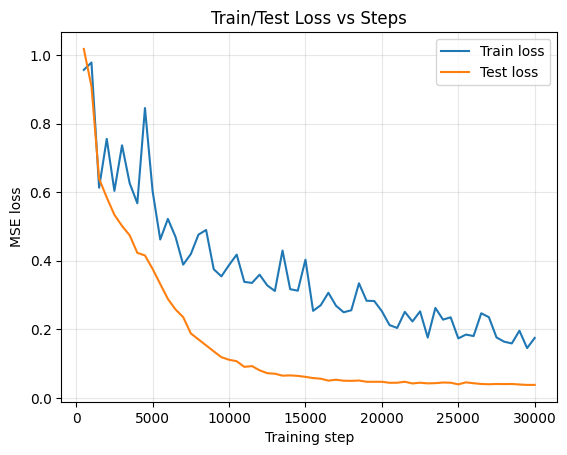

Saved results/loss_vs_steps.png
Saved results/loss_vs_time.png


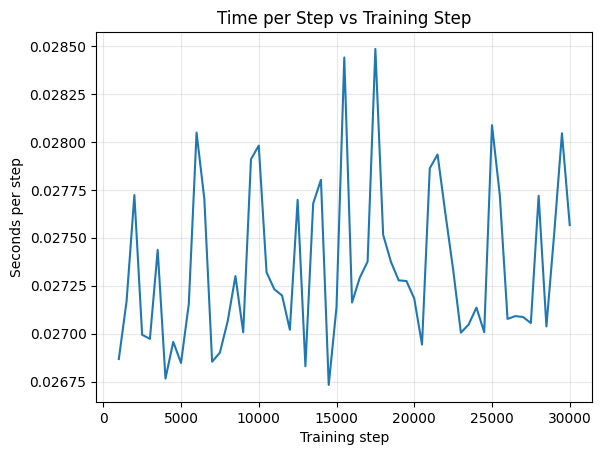

Saved results/time_per_step_vs_steps.png
Mean seconds/step: 0.027349
Std seconds/step: 0.000418


In [3]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np

def plot_history(history_path, save_dir="results"):
    # Load history JSON
    with open(history_path, "r") as f:
        history = json.load(f)

    train_loss = np.array(history["train_loss"])
    test_loss = np.array(history["test_loss"])
    steps = np.array(history["step"])
    wall_time = np.array(history["wall_time"])  # seconds

    os.makedirs(save_dir, exist_ok=True)

    # 1) Loss vs training steps
    plt.figure()
    plt.plot(steps, train_loss, label="Train loss")
    plt.plot(steps, test_loss, label="Test loss")
    plt.xlabel("Training step")
    plt.ylabel("MSE loss")
    plt.title("Train/Test Loss vs Steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_step_path = os.path.join(save_dir, "loss_vs_steps.png")
    plt.savefig(loss_step_path, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved {loss_step_path}")

    # 2) Loss vs wall-clock time (in hours)
    wall_time_hours = wall_time / 3600.0

    plt.figure()
    plt.plot(wall_time_hours, train_loss, label="Train loss")
    plt.plot(wall_time_hours, test_loss, label="Test loss")
    plt.xlabel("Wall-clock time (hours)")
    plt.ylabel("MSE loss")
    plt.title("Train/Test Loss vs Wall-Clock Time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_time_path = os.path.join(save_dir, "loss_vs_time.png")
    plt.savefig(loss_time_path, bbox_inches="tight")
    plt.close()
    print(f"Saved {loss_time_path}")

    # 3) Time per step (seconds/step) vs step
    #   Δtime between checkpoints / Δsteps
    dt = np.diff(wall_time)         # seconds between logs
    dsteps = np.diff(steps)         # steps between logs (should be constant, e.g. 1000)
    time_per_step = dt / dsteps     # seconds per step
    step_centers = steps[1:]        # align each dt with the later step

    plt.figure()
    plt.plot(step_centers, time_per_step)
    plt.xlabel("Training step")
    plt.ylabel("Seconds per step")
    plt.title("Time per Step vs Training Step")
    plt.grid(True, alpha=0.3)
    tps_path = os.path.join(save_dir, "time_per_step_vs_steps.png")
    plt.savefig(tps_path, bbox_inches="tight")
    plt.show()
    # plt.close()
    print(f"Saved {tps_path}")

    # Optionally print summary stats
    print(f"Mean seconds/step: {time_per_step.mean():.6f}")
    print(f"Std seconds/step: {time_per_step.std():.6f}")


if __name__ == "__main__":
    history_path = "results/training_history_6layer.json"  # adjust if needed
    plot_history(history_path, save_dir="results")